# Libraries

In [18]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import matplotlib.ticker as plticker
from matplotlib import rc #for latex use on the plots
from matplotlib import ticker  # for labels formattings
from scipy.stats import poisson
import datetime
from os import getcwd,path
import pandas as pd
from numpy import pi as pi
%matplotlib inline

# Plot Configs

In [11]:
plt.style.use('ggplot')
perso_linewidth = 0.6
# This will change your default rcParams
def init_plotting():
    plt.rcParams['figure.figsize'] = (40,20)
    plt.rcParams['font.size'] = 30
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['axes.titlesize'] = 1.5*plt.rcParams['font.size']
    plt.rcParams['legend.fontsize'] = plt.rcParams['font.size']
    plt.rcParams['xtick.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['ytick.labelsize'] = plt.rcParams['font.size']
    #plt.rcParams['savefig.dpi'] = 2*plt.rcParams['savefig.dpi']
    plt.rcParams['axes.linewidth'] = perso_linewidth
    plt.rcParams['savefig.dpi'] = '300'
    plt.rcParams['savefig.format'] = 'pdf'
    plt.rcParams['axes.facecolor'] = '#D3D3D3'
    plt.rcParams['axes.edgecolor'] = '0'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.color']='white'
    plt.rcParams['grid.linestyle'] = '-'
    plt.rcParams['grid.linewidth'] = '0.4'
    plt.rcParams['axes.axisbelow'] = True
    plt.rcParams['legend.edgecolor'] = 'black'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['lines.markersize']= 18 
    plt.rcParams['lines.markeredgewidth']= '0.1'
    plt.rcParams['lines.color']= 'r' 
    plt.rcParams['lines.marker']= 'o' 
    plt.rcParams['lines.linestyle']= '-' 
    plt.rcParams['xtick.color']= '0'
    plt.rcParams['ytick.color']= '0'
    #plt.rcParams['axes.color_cycle']= ['#3778bf', '#feb308', '#a8a495', '#7bb274', '#825f87']
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['right'].set_visible('False')
    plt.gca().spines['top'].set_visible('False')
    plt.gca().spines['top'].set_color('none')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().yaxis.set_ticks_position('left')
    plt.rcParams['ytick.minor.size']= 1.5
    plt.rcParams['ytick.major.width']= perso_linewidth
    plt.rcParams['ytick.minor.width']= perso_linewidth
    plt.rcParams['xtick.major.width']= perso_linewidth
    plt.rcParams['xtick.minor.width']= perso_linewidth

init_plotting()

plt.close() # this line to avoid an empty plot showing up

### Centering the plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Stochastic Simulation Analysis

### Initial state and constants

#### Simple SIS Model

##### Simple SIS model

\begin{itemize}
\item $E_1:X \rightarrow X+1,Y \rightarrow Y-1$
\item $E_2:X \rightarrow X-1,Y \rightarrow Y+1$
\end{itemize}

In [403]:
initial_state=[30,70]

### Define events increments for Gillepsie's Direct and FR: +1/-1 increment added to each compartment when Ei fires
E1=[-1,1]
E2=[1,-1]
E=np.vstack((E1,E2))


### Define state-change vector for tau-Leap
v1=[-1,1]
v2=[1,-1]
v=np.vstack((v1,v2))


simulation_period=10  ### Years

dt=1.0

#### Boarding School SIR

In [19]:
##### Boarding School

##### Actual case count
csv_file_path=path.join(getcwd(), 'data','Boarding.csv')
df=pd.read_csv(csv_file_path,index_col=0,header=0)

t_reported=df.day
Y_reported=df.flu





N=764
X0=763
Y0=1
Z0=0
initial_state=[X0,Y0,Z0]
# ### Define events increments for Gillepsie's Direct and FR: +1/-1 increment added to each compartment when Ei fires
#E1=[1,0,0]  ## New birth
E1=[-1,1,0] ## Infection
#E3=[-1,0,0] ## Death in S
E2=[0,-1,1] ## Recovery
#E5=[0,-1,0] ## Death in I
#E6=[0,0,-1] ## Death in R


E=np.vstack((E1,E2))


### Define state-change vector for tau-Leap: Signs before each rate
v1=[-1,0]
v2=[1,-1]
v3=[1,0]
v=np.vstack((v1,v2,v3))

simulation_period=1/16  ### Years

dt=0.01

### Rates

In [20]:
def Ratefunc(state,Beta,Gamma):
#     ##### Define rates here:
#     X=state[0]
#     Y=state[1]
#     Beta=0.03
#     Gamma=1/100
#     N=X+Y
#     #######
    
#     R=np.zeros(0)
#     R=np.append(R,[(Beta*X*Y)/N])
#     R=np.append(R,[Gamma*Y])

    X=state[0]
    Y=state[1]
    Z=state[2]
    
    #Beta=1.66
    #Gamma=1/2.2
    
    N=X+Y+Z
    #######
    
    R=np.zeros(0)
    R=np.append(R,[(Beta*X*Y)/N])
    R=np.append(R,[Gamma*Y])


    
    return R

### Gillepsie's Direct

In [55]:
def GillepsieDirect(state,R,E): ## State: current state, R:Rates, E: Event increment, Y: observed values
    
    r_t=sum(R)
    rnd1=random.random()
    dt=(-1/r_t)*np.log(rnd1)
    rnd2=random.random()
    P=rnd2*r_t

      
    l1=np.append([0],R)
    l2=np.cumsum(l1)
    event_to_shoot=np.where(l2>=P)[0][0]-1
    
    state=state+E[event_to_shoot]
    
    
    return state,dt        

### Gillespie's First Reaction

In [14]:
def GillepsieFR(state,R,E):
    
    n_events=len(R)

    rnd=random.random(n_events)
    dts=(-1/R)*np.log(rnd)
    
    
    dt=min(dts)
    event_to_shoot=np.where(dts==dt)[0][0]
    state=state+E[event_to_shoot]
    
    return state,dt    

### $\tau$-Leap

In [21]:
def TauLeap(state,R,v,dt):
    
    Lambda=dt*R
    dMs=np.random.poisson(Lambda)

    dstate=v@dMs.T
    state=state+dstate
    
    return state 

In [302]:
X=np.array([X0])
Y=np.array([Y0])

t=np.array([0])


E=np.zeros(0)

### Define Events
E=np.append(E,[-1,1])
E=np.vstack((E,[1,-1]))


for i in range(5000):
    R=np.zeros(0)
    
    
    ### Define Variables
    Params=[X[i],Y[i]]
    
    ### Define Rates
    R=np.append(R,[(Beta*X[i]*Y[i])/N])
    R=np.append(R,[Gamma*Y[i]])
    
    Params=[X[i],Y[i]]
    
    
    [x,y],dt=GillepsieDirect(Params,R,E)
        
    X=np.append(X,x)
    Y=np.append(Y,y)
    t=np.append(t,t[i]+dt)
    
Y_direct=Y
t_direct=t

In [303]:
X=np.array([X0])
Y=np.array([Y0])

t=np.array([0])


E=np.zeros(0)

### Define Events
E=np.append(E,[-1,1])
E=np.vstack((E,[1,-1]))

for i in range(5000):
    R=np.zeros(0)
    
    
    ### Define Variables
    Params=[X[i],Y[i]]
    
    ### Define Rates
    R=np.append(R,[(Beta*X[i]*Y[i])/N])
    R=np.append(R,[Gamma*Y[i]])

    
    Params=[X[i],Y[i]]
    
    [x,y],dt=GillepsieFR(Params,R,E)
    
    
    X=np.append(X,x)
    Y=np.append(Y,y)
    t=np.append(t,t[i]+dt)
    
Y_FR=Y
t_FR=t

In [306]:
X=np.array([X0])
Y=np.array([Y0])

t=np.array([0])

E=np.zeros(0)

### Define Events
E=np.append(E,[-1,1])
E=np.vstack((E,[1,-1]))

### Define dt
dt=1.0

for i in range(5000):
    R=np.zeros(0)
   
    ### Define Variables
    Params=[X[i],Y[i]]
    
    ### Define Rates
    R=np.append(R,[(Beta*X[i]*Y[i])/N])
    R=np.append(R,[Gamma*Y[i]])
    
    
    Params=np.array([X[i],Y[i]])
    
    if any(Params<=0):
        break
    
    
    [x,y]=TauLeap(Params,R,E,dt)
    
    
    X=np.append(X,x)
    Y=np.append(Y,y)
    t=np.append(t,t[i]+dt)
    
Y_TauLeap=Y
t_TauLeap=t

### Gillepsie Incrementer

In [58]:
def GillepsieSim(initial_state,E,simulation_period,method,Beta,Gamma):
    state=np.array(initial_state)
    n_vars=len(initial_state)
    state.shape=(1,n_vars)
    t=np.array([0])
     
    while (t[-1]/365)<simulation_period:
        R=Ratefunc(state[-1],Beta,Gamma)
        if method=='FR':
            new_state,dt=GillepsieFR(state[-1],R,E)
        if method=='Direct':
            new_state,dt=GillepsieDirect(state[-1],R,E)
        
        state=np.vstack((state,new_state))
        t=np.append(t,t[-1]+dt)
       
    #         if any(state[-1]<=0):
    #             break
    return state,t

### $\tau$-Leap Incrementer

In [16]:
def TauLeapSim(initial_state,v,dt,simulation_period):   ### dt:days, simulation_period:years
    state=np.array(initial_state)
    n_vars=len(initial_state)
    state.shape=(1,n_vars)
    
    simulation_period_days=simulation_period*365
    
    n=int(simulation_period_days/dt)
    
    
    t=np.array([0])
    
    
    for i in range(n):
        
        R=Ratefunc(state[-1])
        new_state=TauLeap(state[-1],R,v,dt)
        state=np.vstack((state,new_state))
        t=np.append(t,t[-1]+dt)
#         if any(state[-1]<=0):
#             break
        
        
    return state,t

# Direct Method Simulations

In [60]:
method='Direct'

#fig2=plt.figure(figsize=(40,24))
#ax21=plt.subplot(311)
#ax22=plt.subplot(312)
#ax23=plt.subplot(313)

n_sims=50
Betas=np.arange(1.5,1.7,0.01)
Gammas=np.arange(0.3,0.5,0.01)


start_time=datetime.datetime.now()

LL=np.zeros(n_sims)
meanLL=np.zeros((len(Betas)*len(Gammas),3))
n=len(Y_reported)

counter=0

for Beta in Betas:
    print("Beta=",Beta)
    for Gamma in Gammas:
        print("Gamma=",Gamma)
        for i in range(n_sims):
            state,t=GillepsieSim(initial_state,E,simulation_period,method,Beta,Gamma)
            X=state[:,0]
            Y=state[:,1]
            Z=state[:,2]

            diff=Y_reported-np.interp(t_reported,t,Y)
            sse=sum(diff**2)
            variance=sse/n
            LL[i]=-(n/2)*np.log(2*pi*variance)-n/2
        
        meanLL[counter]=[Beta,Gamma,np.mean(LL)]
        LL=np.zeros(n_sims)
        counter=counter+1
           


            
            
            
            
            
            
            #     ax21.plot(t,X,'-')
        #     ax22.plot(t,Y,'-')
        #     ax23.plot(t,Z,'-')

#        end_time=datetime.datetime.now()
#        sim_time=str(end_time-start_time)

#        print("Simulation Time: ",sim_time)
#        print("Mean Log-Likelihood: ",np.mean(LL))
#        print("Var Log-Likelihood: ",np.var(LL))

### Actual case count   
# ax22.plot(t_reported,Y_reported,'-ok',linewidth=3,label='Actual reported cases')

# ax21.set_ylabel('Number of Susceptibles')
# ax22.set_ylabel('Number of Infectious')
# ax23.set_ylabel('Number of Recovereds')

# ax21.set_xlim((0,15))
# ax22.set_xlim((0,15))
# ax23.set_xlim((0,15))

# fig2.suptitle("Gillepsie's Direc Method - "+str(n_sims)+' Trajectories (Simulation time: '+sim_time+')',fontsize=24)
# ax22.legend()
# plt.show()

Beta= 1.5
Gamma= 0.3


C:\Users\arashs\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars


Gamma= 0.31
Gamma= 0.32
Gamma= 0.33
Gamma= 0.34
Gamma= 0.35000000000000003
Gamma= 0.36000000000000004
Gamma= 0.37000000000000005
Gamma= 0.38000000000000006
Gamma= 0.39000000000000007
Gamma= 0.4000000000000001
Gamma= 0.4100000000000001
Gamma= 0.4200000000000001
Gamma= 0.4300000000000001
Gamma= 0.4400000000000001
Gamma= 0.4500000000000001
Gamma= 0.46000000000000013
Gamma= 0.47000000000000014
Gamma= 0.48000000000000015
Gamma= 0.49000000000000016
Beta= 1.51
Gamma= 0.3
Gamma= 0.31
Gamma= 0.32
Gamma= 0.33
Gamma= 0.34
Gamma= 0.35000000000000003
Gamma= 0.36000000000000004
Gamma= 0.37000000000000005
Gamma= 0.38000000000000006
Gamma= 0.39000000000000007
Gamma= 0.4000000000000001
Gamma= 0.4100000000000001
Gamma= 0.4200000000000001
Gamma= 0.4300000000000001
Gamma= 0.4400000000000001
Gamma= 0.4500000000000001
Gamma= 0.46000000000000013
Gamma= 0.47000000000000014
Gamma= 0.48000000000000015
Gamma= 0.49000000000000016
Beta= 1.52
Gamma= 0.3
Gamma= 0.31
Gamma= 0.32
Gamma= 0.33
Gamma= 0.34
Gamma= 0.35000

Gamma= 0.39000000000000007
Gamma= 0.4000000000000001
Gamma= 0.4100000000000001
Gamma= 0.4200000000000001
Gamma= 0.4300000000000001
Gamma= 0.4400000000000001
Gamma= 0.4500000000000001
Gamma= 0.46000000000000013
Gamma= 0.47000000000000014
Gamma= 0.48000000000000015
Gamma= 0.49000000000000016
Beta= 1.6800000000000002
Gamma= 0.3
Gamma= 0.31
Gamma= 0.32
Gamma= 0.33
Gamma= 0.34
Gamma= 0.35000000000000003
Gamma= 0.36000000000000004
Gamma= 0.37000000000000005
Gamma= 0.38000000000000006
Gamma= 0.39000000000000007
Gamma= 0.4000000000000001
Gamma= 0.4100000000000001
Gamma= 0.4200000000000001
Gamma= 0.4300000000000001
Gamma= 0.4400000000000001
Gamma= 0.4500000000000001
Gamma= 0.46000000000000013
Gamma= 0.47000000000000014
Gamma= 0.48000000000000015
Gamma= 0.49000000000000016
Beta= 1.6900000000000002
Gamma= 0.3
Gamma= 0.31
Gamma= 0.32
Gamma= 0.33
Gamma= 0.34
Gamma= 0.35000000000000003
Gamma= 0.36000000000000004
Gamma= 0.37000000000000005
Gamma= 0.38000000000000006
Gamma= 0.39000000000000007
Gamma= 

NameError: name 'meanLL' is not defined

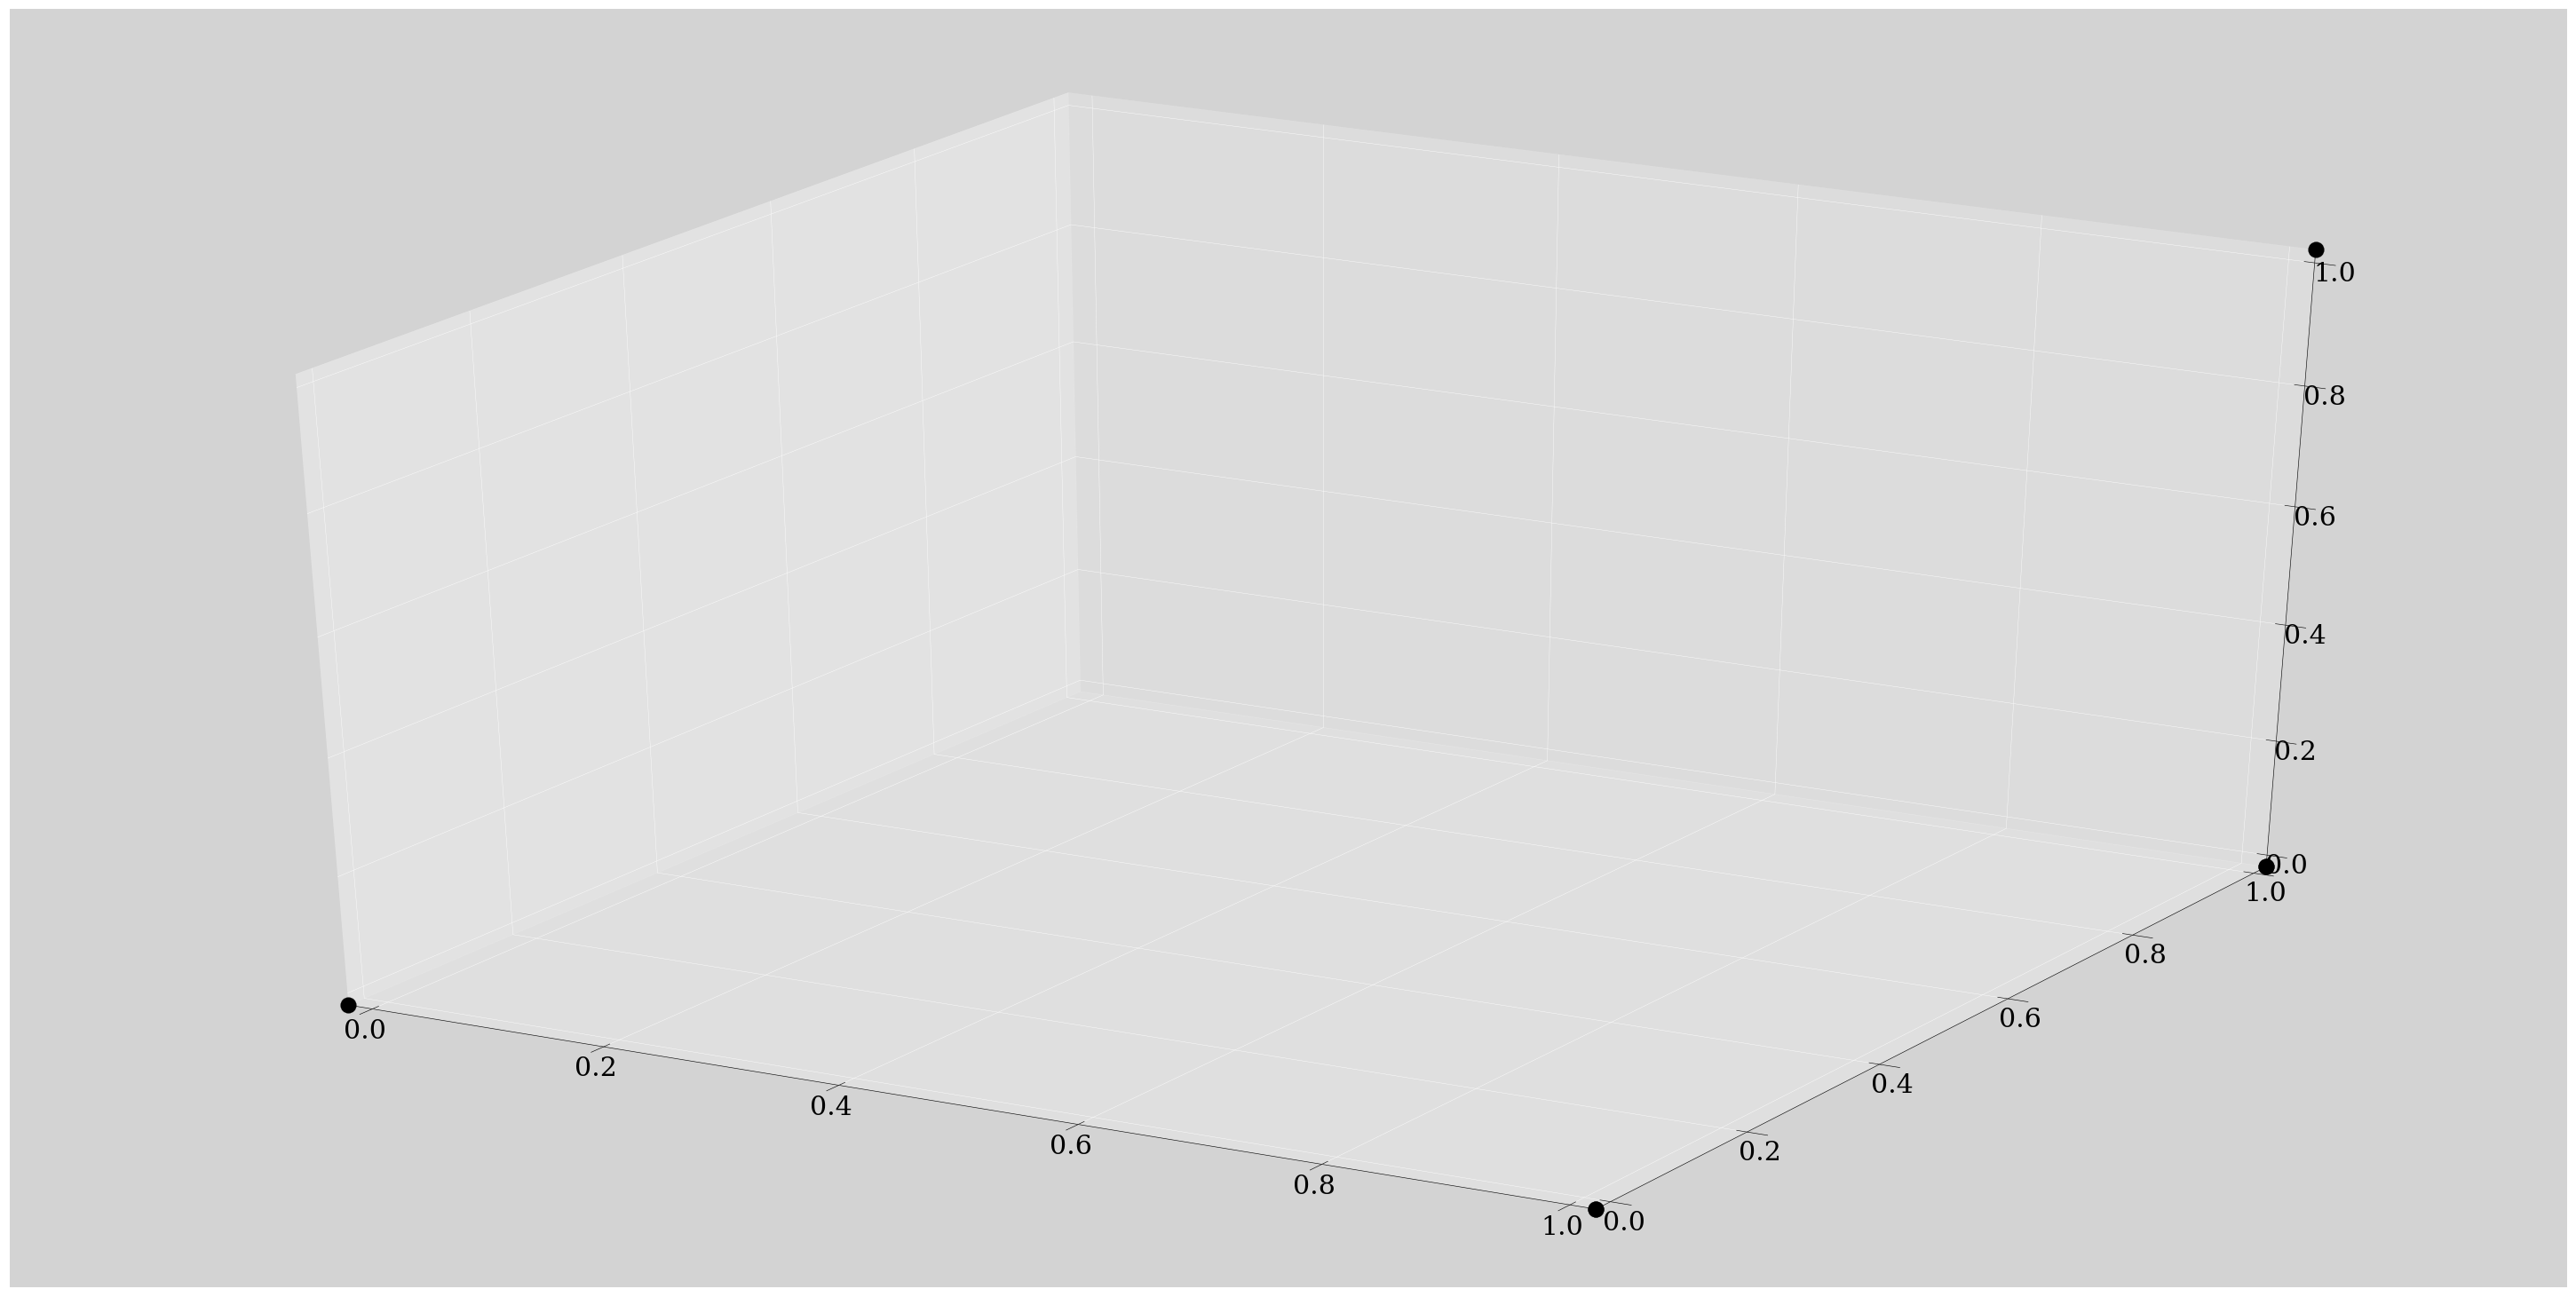

In [17]:
fig33=plt.figure()
ax331=Axes3D(fig33)
ax331.scatter(meanLL[:,0],meanLL[:,1],meanLL[:,2])

In [ ]:
a=max(meanLL[:,2])
b=meanLL[meanLL[:,2]==a]
b

# FR Simulations

In [ ]:
method='FR'

fig3=plt.figure(figsize=(40,24))
ax31=plt.subplot(311)
ax32=plt.subplot(312)
ax33=plt.subplot(313)

n_sims=100

start_time=datetime.datetime.now()

for i in range(n_sims):
    state,t=GillepsieSim(initial_state,E,simulation_period,method)
    X=state[:,0]
    Y=state[:,1]
    Z=state[:,2]
    ax31.plot(t,X,'-')
    ax32.plot(t,Y,'-')
    ax33.plot(t,Z,'-')    
    
end_time=datetime.datetime.now()
sim_time=str(end_time-start_time)


### Actual case count   
ax32.plot(t_reported,Y_reported,'-ok',linewidth=3,label='Actual reported cases')

ax31.set_ylabel('Number of Susceptibles')
ax32.set_ylabel('Number of Infectious')
ax33.set_ylabel('Number of Recovereds')


ax31.set_xlim((0,15))
ax32.set_xlim((0,15))
ax33.set_xlim((0,15))



fig3.suptitle("Gillepsie's First Reaction Method - "+str(n_sims)+' Trajectories (Simulation time: '+sim_time+')',fontsize=24)
ax32.legend()
plt.show()

# $\tau$-Leap Simulations

TypeError: Ratefunc() missing 2 required positional arguments: 'Beta' and 'Gamma'

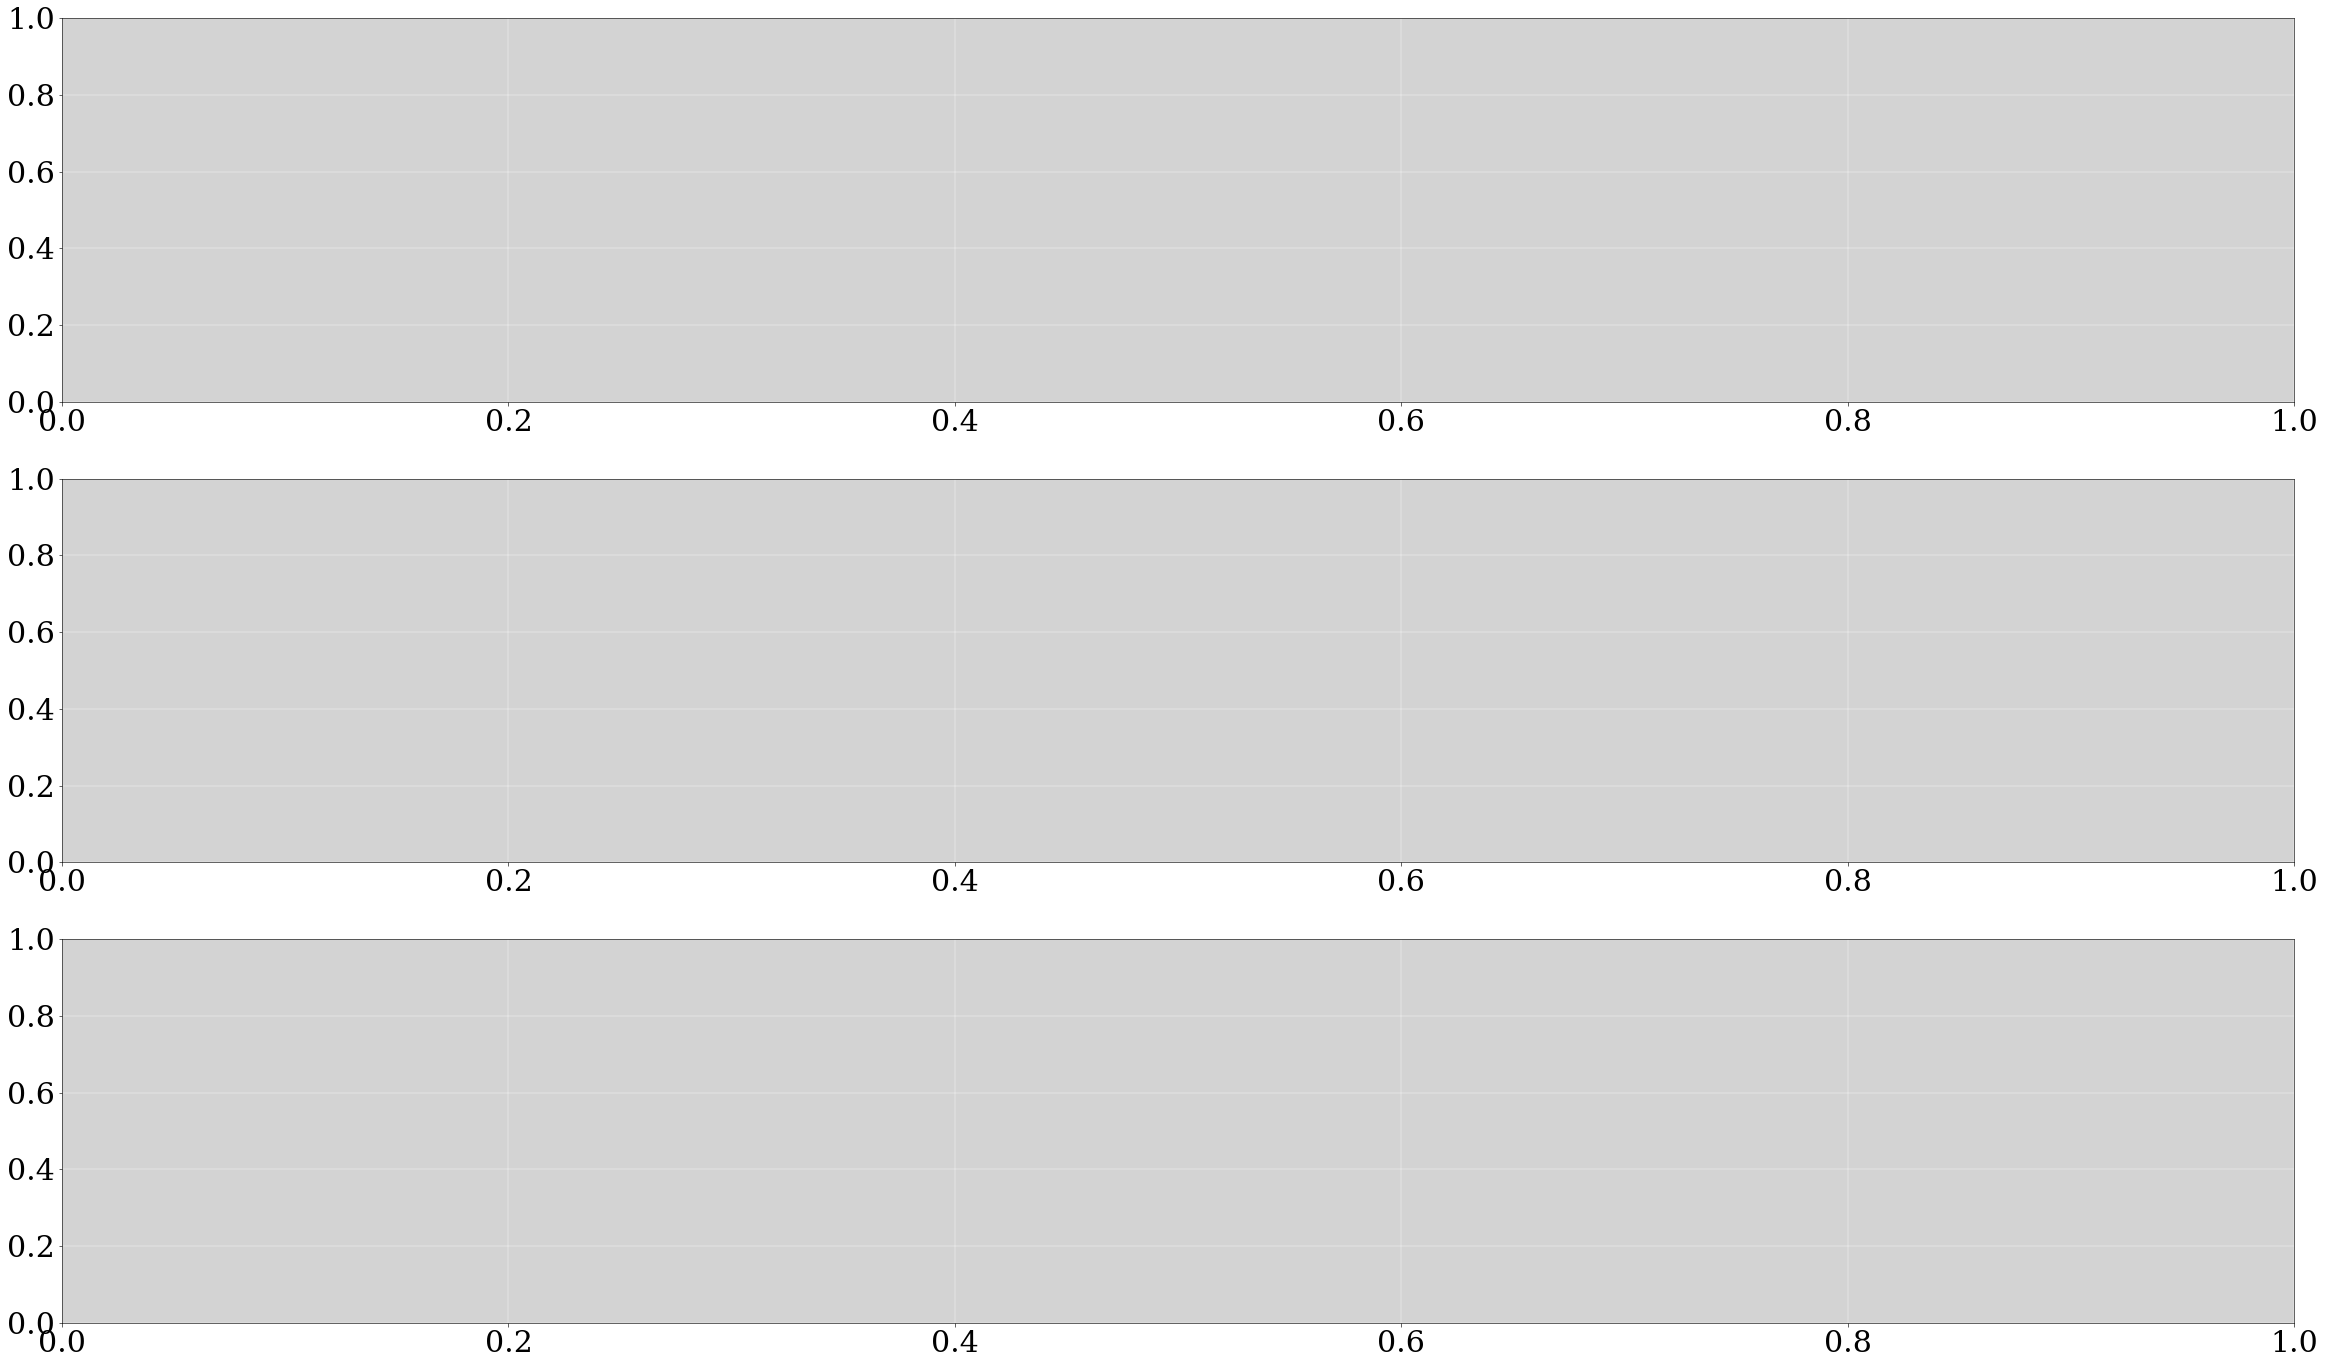

In [22]:
fig4=plt.figure(figsize=(40,24))
ax41=plt.subplot(311)
ax42=plt.subplot(312)
ax43=plt.subplot(313)

n_sims=100

start_time=datetime.datetime.now()

for i in range(n_sims):
    state,t=TauLeapSim(initial_state,v,dt,simulation_period)

    X=state[:,0]
    Y=state[:,1]
    Z=state[:,2]
    
    ax41.plot(t,X,'-')
    ax42.plot(t,Y,'-')
    ax43.plot(t,Z,'-')
    
end_time=datetime.datetime.now()
sim_time=str(end_time-start_time)

### Actual case count   
ax42.plot(t_reported,Y_reported,'-ok',linewidth=3,label='Actual reported cases')

ax41.set_ylabel('Number of Susceptibles')
ax42.set_ylabel('Number of Infectious')
ax43.set_ylabel('Number of Recovereds')


ax41.set_xlim((0,15))
ax42.set_xlim((0,15))
ax43.set_xlim((0,15))



fig4.suptitle(r"$\tau$-Leap Method (dt: "+str(dt) + " days) - "+str(n_sims)+' Trajectories (Simulation time: '+sim_time+')',fontsize=24)
ax42.legend()
plt.show()